# PyTorch Transfer Learning

#### **1. What is transfer learning?**
So far we have built many models from scratch. However, this is not always the best approach. As we also expereinced our model performed poorly. In many cases, we can use a pre-trained model and fine-tune it to our specific problem. This is called transfer learning.<br>
With the application of **Transfer Learning** we can take weights another model has learned from some other probelem and use them to solve our problem. This is especially useful when we have a small dataset. <br>
In this notebook, we will use a pre-trained model called **ResNet18** and fine-tune it to our pizza-steak-sushi problem. <br>

#### **2. Why Transfer Learning?**
- **Less Data**: Deep learning models require a lot of data. However, in practice, we often have a small dataset. Transfer learning helps us to use pre-trained models and fine-tune them to our specific problem.
- **Computation**: Training a deep learning model from scratch requires a lot of computation. However, with transfer learning, we can use pre-trained models and fine-tune them to our specific problem. This requires less computation.
- **Time**: Training a deep learning model from scratch requires a lot of time. However, with transfer learning, we can use pre-trained models and fine-tune them to our specific problem. This requires less time. <br>
Also, A finding from a recent machine learning research paper recommended practitioners use transfer learning wherever possible.


![Transfer Learning Image](https://www.techtarget.com/rms/onlineimages/how_transfer_learning_works-f.png)


# 1. Getting started and downloading the data

In [4]:
import sys
sys.path.append('../2.Going_Modular')

In [ ]:
%pip install -q torchinfo 

In [ ]:
import os
import zipfile
import requests
from pathlib import Path
from going_modular import data_setup, engine # type: ignore

import torch
import torchvision

import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary



In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
data_path =  Path('data')
image_path= data_path/ 'pizza_steak_sushi'

if image_path.exists():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
        print("downloading data . . .")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
    
    with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as z:
        z.extractall(image_path)
    
    os.remove(data_path/'pizza_steak_sushi.zip')
    

data\pizza_steak_sushi already exists


In [13]:

train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create DataLoader

When using a pretrained model, it's important that our custom data going into the model is prepared in the same way as the original training data that went into the model.

In [ ]:
#Creating Transforms 
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [42]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [43]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2a2135ca490>,
 ['pizza', 'steak', 'sushi'])

In [ ]:

weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.resnet50(weights=weights).to(device)  # Load in the ResNet50 model with the pre-trained weights 


In [67]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
# Freeze all base layers of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc #fc is classifier layer in resnet50

Sequential(
  (0): Linear(in_features=2048, out_features=3, bias=True)
)

In [71]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.fc = torch.nn.Sequential( 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [73]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [74]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0671 | train_acc: 0.3711 | test_loss: 0.9851 | test_acc: 0.7424
Epoch: 2 | train_loss: 0.8752 | train_acc: 0.7227 | test_loss: 0.8942 | test_acc: 0.7330
Epoch: 3 | train_loss: 0.7503 | train_acc: 0.8711 | test_loss: 0.8038 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.6718 | train_acc: 0.9375 | test_loss: 0.7385 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5992 | train_acc: 0.8242 | test_loss: 0.7115 | test_acc: 0.8759
[INFO] Total training time: 60.347 seconds


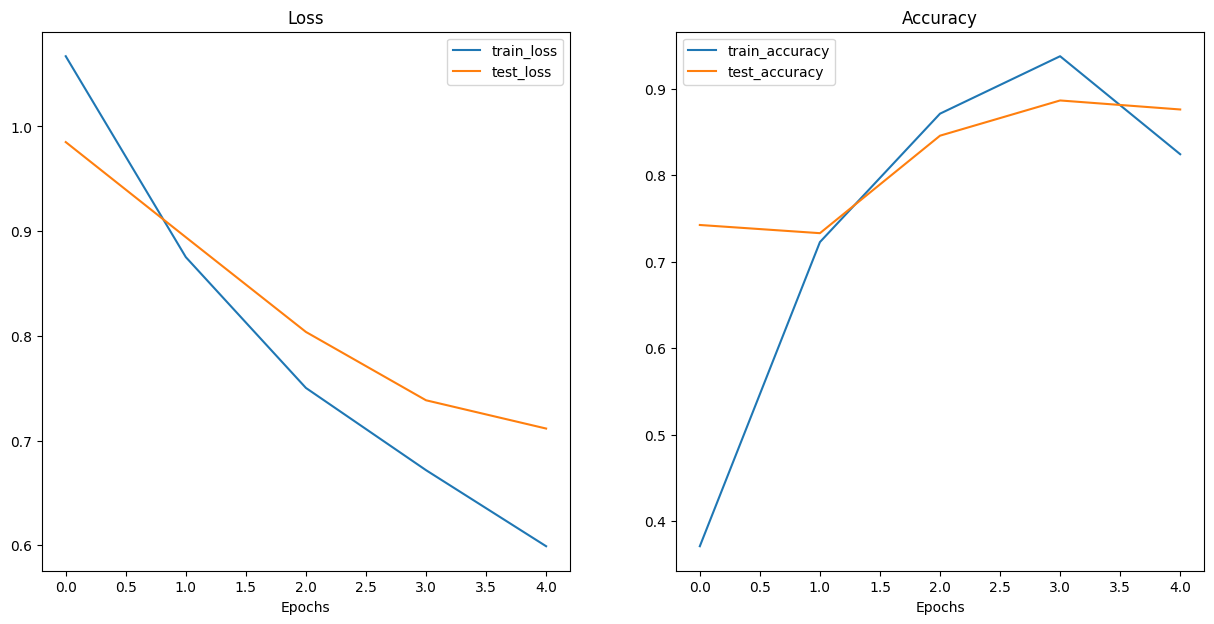

In [76]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

### Make Prediction

In [77]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

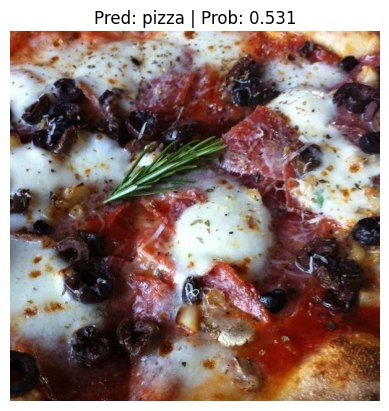

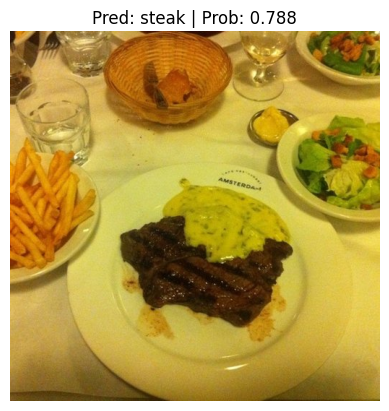

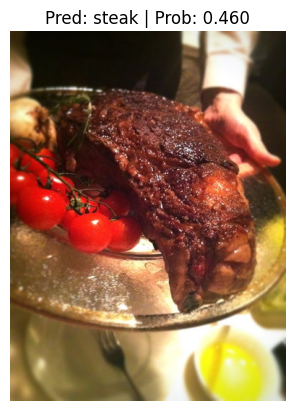

In [78]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

data\04-pizza.jpeg already exists, skipping download.


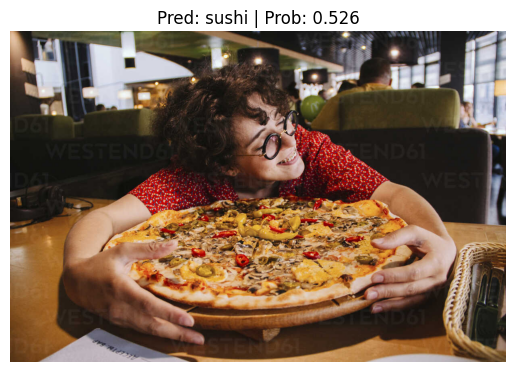

In [81]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://us.images.westend61.de/0001075956pw/happy-woman-holding-pizza-on-wooden-table-while-sitting-in-restaurant-CAVF54562.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)